# Imports

In [53]:

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Load datasets

In [54]:
import data_func.read_data as read_data

dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()

# Data clean up

In [55]:
# Making sure that target values line up with x_values

def data_allign(x_train, y_train):
  
  y_train.dropna(inplace=True)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train

import data_func.aggregation as data_agg

categorical_features = ['dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx', 'precip_type_5min:idx', 'snow_drift:idx']

for i in range(len(X_frames_train)):

  X_frames_train[i] = data_agg.gen_agg(X_frames_train[i], 'mean')
  X_frames_train[i], Y_frames_train[i] = data_allign(X_frames_train[i], Y_frames_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = data_agg.gen_agg(X_frames_test[j], 'mean')

print(len(X_frames_train[0]))
print(len(Y_frames_train[0]))
print(len(X_frames_test[0]))

29667
29667
720


# Feature engineering

In [56]:
import data_func.timeseasonality as DTS
import data_func.date_forecast as DTF
import data_func.one_hot_encoding as OHE

categorical_features = ['dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx', 'precip_type_5min:idx']


for i in range(len(X_frames_train)):
    X_frames_train[i] = DTS.append_seasonal_columns(X_frames_train[i])
    X_frames_train[i] = DTF.date_forecast_columns(X_frames_train[i])
    # X_frames_train[i] = OHE.one_hot_encode(X_frames_train[i], categorical_features)
    # X_frames_train[i].drop(columns=['absolute_humidity_2m:gm3'], inplace=True)
    # X_frames_train[i].drop(columns=['air_density_2m:kgm3'], inplace=True)
    # X_frames_train[i]['ceiling_height_agl:m'] = X_frames_train[i]['ceiling_height_agl:m'].fillna(0)
    # X_frames_train[i]['cloud_base_agl:m'] = X_frames_train[i]['cloud_base_agl:m'].fillna(100000)



for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    X_frames_test[i] = DTF.date_forecast_columns(X_frames_test[i])
    # X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], categorical_features)





# Training the model

In [57]:

# Split the data into training and validation sets

x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(X_frames_train[0], Y_frames_train[0], test_size=0.17, random_state=42)
x_train_b, x_val_b, y_train_b, y_val_b = train_test_split(X_frames_train[1], Y_frames_train[1], test_size=0.17, random_state=42)
x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(X_frames_train[2], Y_frames_train[2], test_size=0.17, random_state=42)

# Use params from hyperparameter tuning using optuna
params_a = {'objective': 'RMSE', 'colsample_bylevel': 0.042552213124753616, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}
params_b = {'objective': 'MAE', 'colsample_bylevel': 0.08488285044426233, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7370569178270235}
params_c = {'objective': 'RMSE', 'colsample_bylevel': 0.07603707767168257, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}

model_a = CatBoostRegressor(**params_a)
model_b = CatBoostRegressor(**params_b)
model_c = CatBoostRegressor(**params_c)


model_a.fit(x_train_a, y_train_a)
model_b.fit(x_train_b, y_train_b)
model_c.fit(x_train_c, y_train_c)

Learning rate set to 0.067922
0:	learn: 1191.1653742	total: 2.21ms	remaining: 2.21s
1:	learn: 1130.3608827	total: 58.9ms	remaining: 29.4s
2:	learn: 1089.9145664	total: 62.1ms	remaining: 20.7s
3:	learn: 1047.0317151	total: 111ms	remaining: 27.6s
4:	learn: 1000.0418228	total: 114ms	remaining: 22.8s
5:	learn: 957.2686810	total: 166ms	remaining: 27.5s
6:	learn: 953.8009554	total: 168ms	remaining: 23.8s
7:	learn: 916.4386234	total: 171ms	remaining: 21.2s
8:	learn: 904.6078967	total: 174ms	remaining: 19.1s
9:	learn: 877.1931194	total: 176ms	remaining: 17.4s
10:	learn: 842.0679853	total: 226ms	remaining: 20.4s
11:	learn: 815.2522476	total: 245ms	remaining: 20.2s
12:	learn: 791.4636625	total: 247ms	remaining: 18.7s
13:	learn: 764.8551898	total: 258ms	remaining: 18.2s
14:	learn: 737.5921076	total: 268ms	remaining: 17.6s
15:	learn: 715.2014321	total: 325ms	remaining: 20s
16:	learn: 695.9172589	total: 329ms	remaining: 19s
17:	learn: 695.4265060	total: 330ms	remaining: 18s
18:	learn: 695.4262209	t

# Evaluate prediction

In [58]:
# Evaluate the model based on the validation data

mse_a = mean_squared_error(y_val_a, model_a.predict(x_val_a))
print("MSE for A: ", mse_a)
mse_b = mean_squared_error(y_val_b, model_b.predict(x_val_b))
print("MSE for B: ", mse_b)
mse_c = mean_squared_error(y_val_c, model_c.predict(x_val_c))
print("MSE for C: ", mse_c)
print("Mean MSE: ", (mse_a + mse_b + mse_c) / 3)

# Evaluate the predictions

score_a = model_a.score(x_val_a, y_val_a)
score_b = model_b.score(x_val_b, y_val_b)
score_c = model_c.score(x_val_c, y_val_c)

print("Score A: ", score_a)
print("Score B: ", score_b)
print("Score C: ", score_c)
print('')






MSE for A:  133665.86212227514
MSE for B:  4320.184092116235
MSE for C:  1945.0215979316315
Mean MSE:  46643.68927077433
Score A:  0.9027034080443017
Score B:  0.8878508291628073
Score C:  0.934824840891275



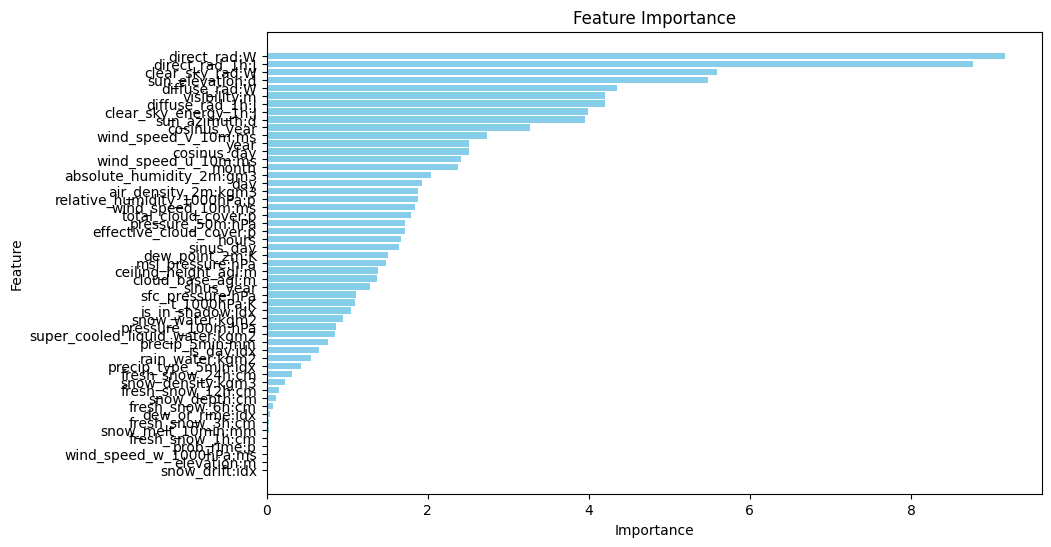

In [59]:
import matplotlib.pyplot as plt

feature_importance = model_a.get_feature_importance()
# Create a DataFrame to store feature names and their importance scores
importance_df = pd.DataFrame({'Feature': x_train_a.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance scores in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot to visualize feature importance

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
plt.show()

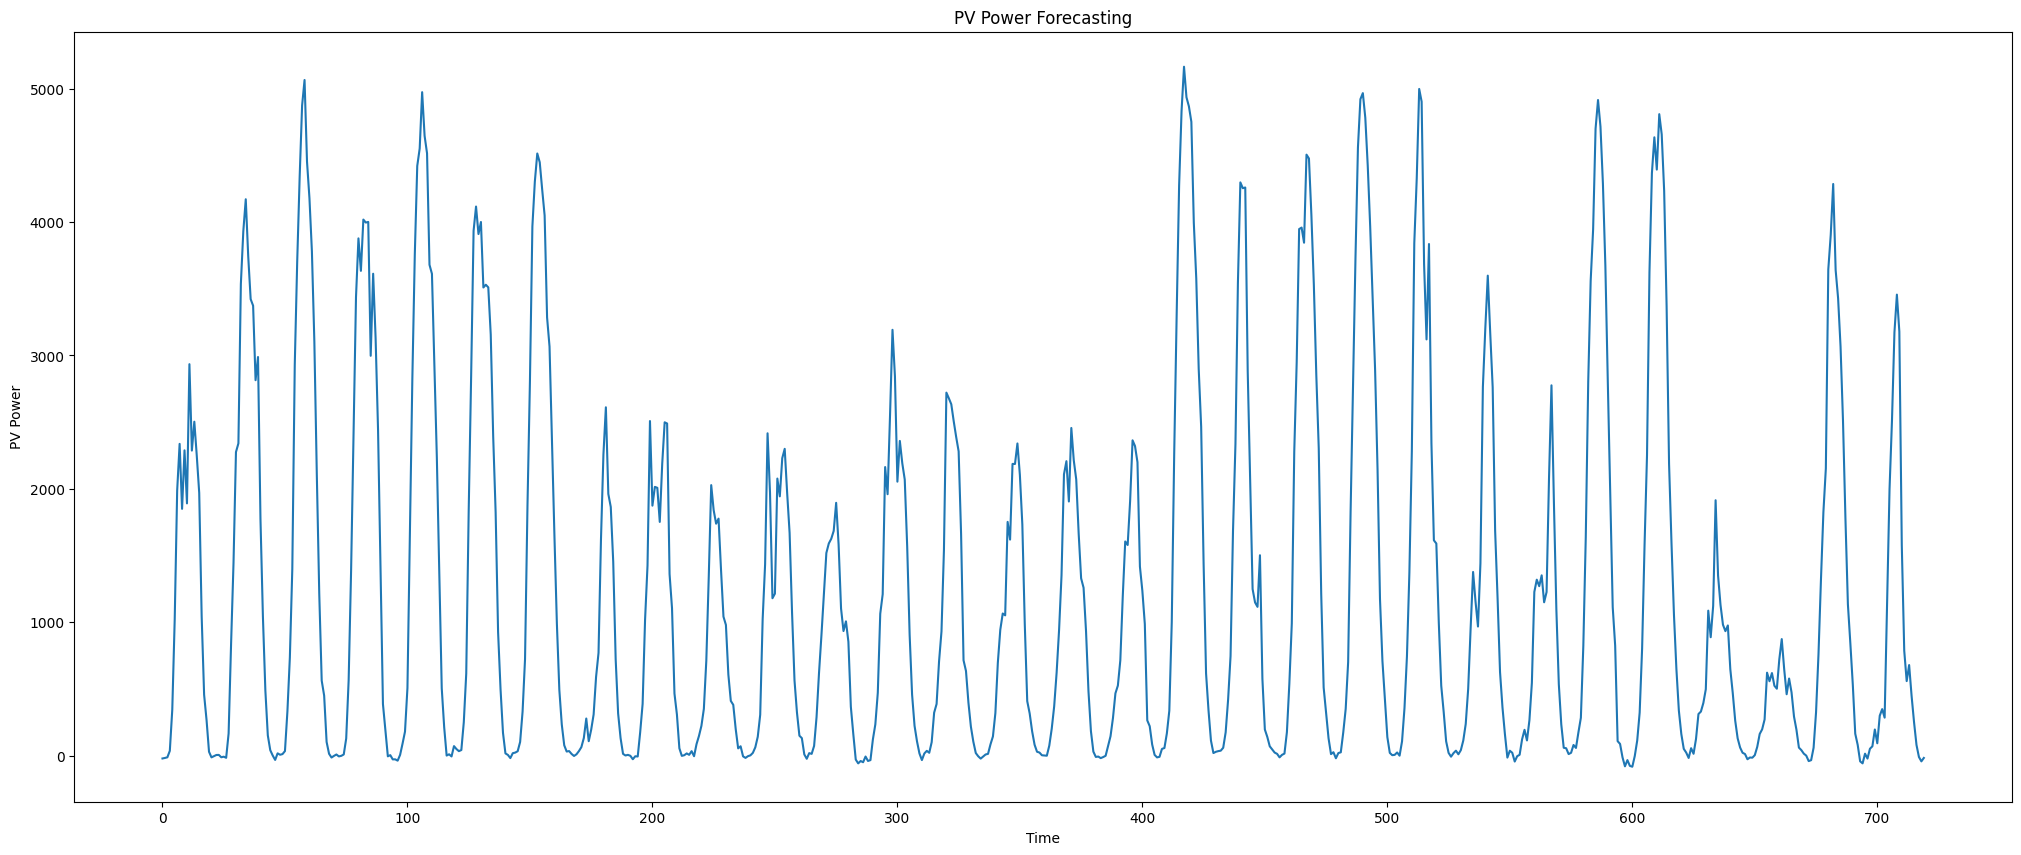

In [60]:

#Plot the results
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.iloc[0:720]
plt.figure(figsize=(25, 10))
plt.plot(y_pred)
plt.title('PV Power Forecasting')
plt.xlabel('Time')
plt.ylabel('PV Power')
plt.show()

# Make predictions

In [61]:
# Sort columns

def sort_columns(df_train: pd.DataFrame, df_test: pd.DataFrame):
    common_columns = df_train.columns.intersection(df_test.columns)

    df_train = df_train[common_columns]
    df_test = df_test[common_columns]

for i in range (3):
    sort_columns(X_frames_train[i], X_frames_test[i])

# Train the model on the entire training data
model_a.fit(X_frames_train[0], Y_frames_train[0])
model_b.fit(X_frames_train[1], Y_frames_train[1])
model_c.fit(X_frames_train[2], Y_frames_train[2])

y_pred_a = model_a.predict(X_frames_test[0])
y_pred_b = model_b.predict(X_frames_test[1])
y_pred_c = model_c.predict(X_frames_test[2])
print(len(y_pred_a))

y_pred = np.concatenate((y_pred_a, y_pred_b, y_pred_c), axis=0)



Index(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10

In [62]:
print(len(y_pred_a), len(X_frames_test[0]))
print(len(y_pred_b), len(X_frames_test[1]))
print(len(y_pred_c), len(X_frames_test[2]))

720 720
720 720
720 720


In [63]:
for i in range(len(y_pred)):
    if y_pred[i] < 0: 
        y_pred[i] = 0



# Create submission

In [64]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submission.csv', index=False)